In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm

#import matplotlibmatplotlib.rcParams['axes.labelsize'] = 14
#matplotlib.rcParams['xtick.labelsize'] = 12
#matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'

Time series forecasting is the use of a model to predict future values based on previously observed values.  
Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post

In [3]:
df = pd.read_excel("/home/johan/repos/GitHub/Time-SeriesForecasting/Data/Sample - Superstore.xls")
#print(df[0:2])
furniture = df.loc[df['Category'] == 'Furniture']

In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [5]:
furniture[0:2]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

In [7]:
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [8]:
#furniture = furniture.groupby('Order Date')
#furniture['Sales'].sum().reset_index()
#print(furniture[0:4])

In [9]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-13', '2014-01-14', '2014-01-16',
               '2014-01-19', '2014-01-20',
               ...
               '2017-12-28', '2017-12-28', '2017-12-28', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

In [19]:
print('furniture[Sales].shape:',furniture['Sales'].shape)
y = furniture['Sales'].resample('MS').mean()
print('y:',y[1],'shape:', y.shape)

furniture[Sales].shape: (2121,)
y: 262.8082857142857 shape: (48,)


In [20]:
y['2017':]

Order Date
2017-01-01    248.501333
2017-02-01    264.089900
2017-03-01    286.669600
2017-04-01    206.044502
2017-05-01    319.953928
2017-06-01    372.717386
2017-07-01    227.173500
2017-08-01    395.945487
2017-09-01    349.737422
2017-10-01    308.226313
2017-11-01    374.310253
2017-12-01    296.296857
Freq: MS, Name: Sales, dtype: float64

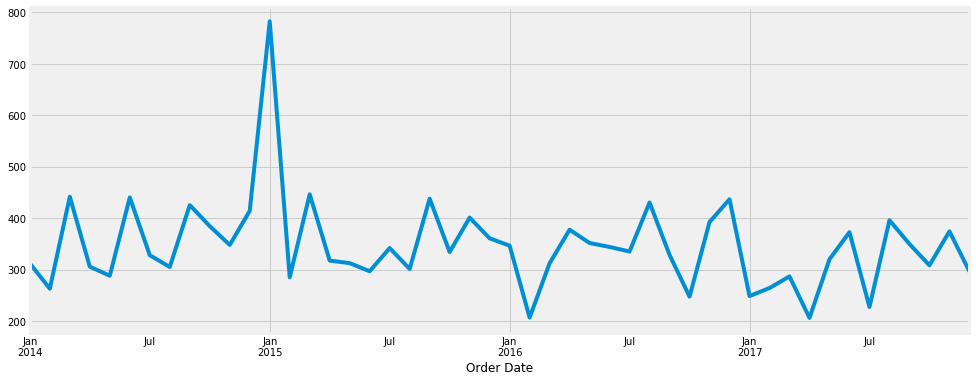

In [21]:
y.plot(figsize=(15, 6))
plt.show()

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

**Systematic:** Components of the time series that have consistency or recurrence and can be described and modeled.   
**Non-Systematic:**Components of the time series that cannot be directly modeled.

A given time series is thought to consist of **three systematic components including level, trend, seasonality, and one non-systematic component called noise.**

These components are defined as follows:

**Level:** The average value in the series.   
**Trend:** The increasing or decreasing value in the series.   
**Seasonality:** The repeating short-term cycle in the series.  
**Noise:** The random variation in the series.  


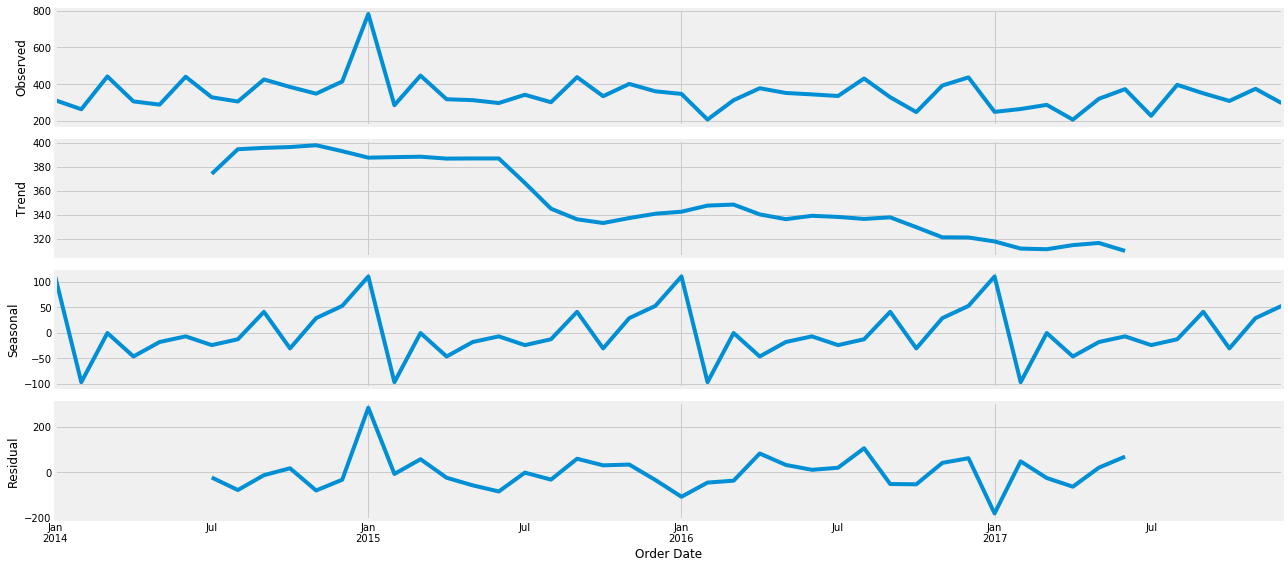

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.